In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img

import cv2
import itertools
import pathlib
import warnings
from PIL import Image
from random import randint
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix


from tensorflow import keras
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

from distutils.dir_util import copy_tree, remove_tree

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.12.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp -r /content/gdrive/MyDrive/Dataset .

Mounted at /content/gdrive


In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/Dataset', output="output", seed=1345, ratio=(.8, 0.1,0.1))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 6400 files [00:00, 8708.01 files/s]


In [ ]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/train",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/test",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/val",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

Found 5119 files belonging to 4 classes.
Found 642 files belonging to 4 classes.
Found 639 files belonging to 4 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)
train_ds

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
model.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.20))

model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(64,"relu"))
model.add(keras.layers.Dense(4,"softmax"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy"])

In [ ]:
hist = model.fit(train_ds,validation_data=val_ds,epochs=100, batch_size=64, verbose=1)

Epoch 1/100
80/80 [==============================] - 22s 77ms/step - loss: 1.2381 - accuracy: 0.4854 - val_loss: 1.0252 - val_accuracy: 0.5008
Epoch 2/100
80/80 [==============================] - 2s 29ms/step - loss: 0.9590 - accuracy: 0.5446 - val_loss: 0.8731 - val_accuracy: 0.6150
Epoch 3/100
80/80 [==============================] - 2s 29ms/step - loss: 0.8438 - accuracy: 0.6167 - val_loss: 0.7823 - val_accuracy: 0.6651
Epoch 4/100
80/80 [==============================] - 3s 34ms/step - loss: 0.7714 - accuracy: 0.6572 - val_loss: 0.6564 - val_accuracy: 0.7074
Epoch 5/100
80/80 [==============================] - 2s 29ms/step - loss: 0.6744 - accuracy: 0.7058 - val_loss: 0.6721 - val_accuracy: 0.6933
Epoch 6/100
80/80 [==============================] - 3s 30ms/step - loss: 0.5707 - accuracy: 0.7650 - val_loss: 0.5156 - val_accuracy: 0.7872
Epoch 7/100
80/80 [==============================] - 2s 30ms/step - loss: 0.4811 - accuracy: 0.8031 - val_loss: 0.3504 - val_accuracy: 0.8732
Epoch

In [ ]:
get_ac = hist.history['accuracy']
get_los = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

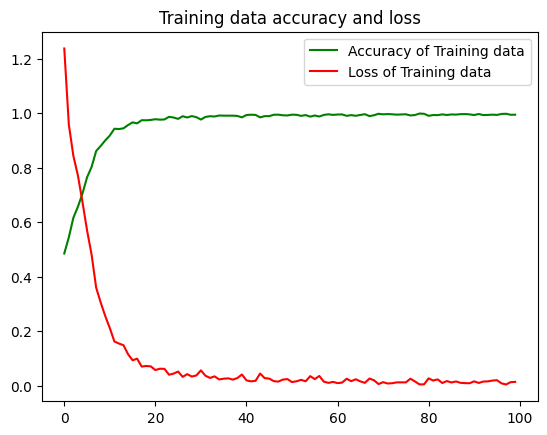

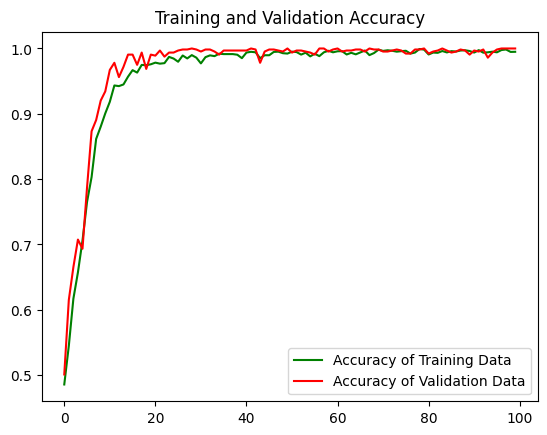

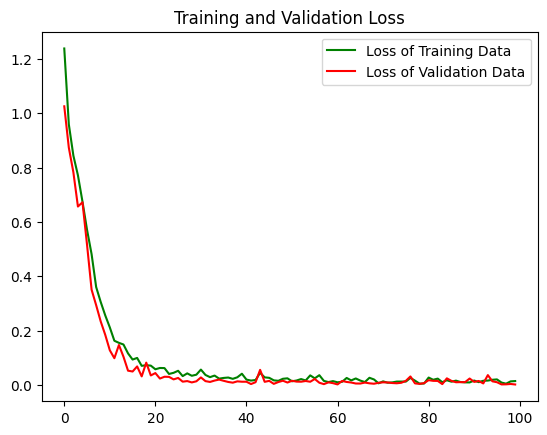

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
import os

# Assuming your data is organized into folders, where each folder represents a class
data_dir = "/content/Dataset"  # Replace with the path to your data directory

true_labels = []
class_labels = sorted(os.listdir(data_dir))  # Get a sorted list of class labels
class_labels


['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

In [ ]:
loss, accuracy = model.evaluate(test_ds)

11/11 [==============================] - 0s 14ms/step - loss: 0.0226 - accuracy: 0.9953


In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'green'})
            
        else:
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])